In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from linear_opt.lin_metabolism import MW_C_ATOM
from linear_opt.lin_metabolism import LinearMetabolicModel
from linear_opt.lin_metabolism import GrowthRateOptParams
from matplotlib import pyplot as plt
from os import path

from linear_opt.lin_metabolism import MW_C_ATOM
from linear_opt.lin_metabolism import LinearMetabolicModel
from linear_opt.lin_metabolism import GrowthRateOptParams

# Approximate concentrations and ratios for plotting
# Based on Bennett et al. 2009 measurements in E. coli
DEFAULT_ATP = 1.4e-6
DEFAULT_NADH = 1.2e-7
DEFAULT_C_OX = 1e-6  # Picked a number similar to ATP. 
DEFAULT_RE = 10
DEFAULT_RA = 0.3
DEFAULT_OPT_VALS = dict(do_dilution=True, dilute_as_sum=True,
                        fixed_ATP=DEFAULT_ATP, fixed_ECH=DEFAULT_NADH,
                        fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)

In [2]:
print('Loading fermentation model...')
model_dir = '../models/linear/fermentation/'
m_fname = path.join(model_dir, 'glucose_ferm_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_ferm_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

Loading fermentation model...


In [10]:
lam_no_ATP_homeostasis = lam.drop_process('ATP_homeostasis')
lam_no_ECH_homeostasis = lam.drop_process('ECH_homeostasis')
lam_no_homeostasis = lam_no_ECH_homeostasis.drop_process('ATP_homeostasis')

lam_dict = {'full': lam, 'no_ATP_homeostasis': lam_no_ATP_homeostasis,
            'no_ECH_homeostasis': lam_no_ECH_homeostasis,
            'no_homeostasis': lam_no_homeostasis}

In [11]:
# Can the model grow? 
params = GrowthRateOptParams(min_phi_O=0.4, fixed_C_ox=1e-5,
                             **DEFAULT_OPT_VALS)
opt, opt_prob = lam.maximize_growth_rate(params)
print(opt)

# Can the model grow without ECH homeostasis? NO
params = GrowthRateOptParams(min_phi_O=0.4, fixed_C_ox=1e-5,
                             **DEFAULT_OPT_VALS)
opt, opt_prob = lam_no_ECH_homeostasis.maximize_growth_rate(params)
print(opt)

1.6193805738016238
0.0


/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [29]:
print('Optimizing over a range of fixed C_ox conces...')
C_ox_concs = np.logspace(-8, 1, 50)
results = []

for c in C_ox_concs:
    # Make fresh parameters with a new max_lambda_hr
    params = GrowthRateOptParams(min_phi_O=0.4, maintenance_cost=0,
                                 fixed_C_ox=c, **DEFAULT_OPT_VALS)
    
    for label, my_lam in lam_dict.items():
        opt, opt_prob = my_lam.maximize_growth_rate(params)
        d = my_lam.results_as_dict(opt_prob, params)
        d['model'] = label
        results.append(d)

conc_df = pd.DataFrame(results)

Optimizing over a range of fixed C_ox conces...


/Users/flamholz/Documents/workspace/redox-proteome/notebooks/linear_opt/lin_metabolism.py:740: RuntimeWarning: invalid value encountered in scalar divide
  S6_lb = num / denom
/Users/flamholz/Documents/workspace/redox-proteome/notebooks/linear_opt/lin_metabolism.py:745: RuntimeWarning: invalid value encountered in scalar divide
  S6_ub = num / denom
/Users/flamholz/Documents/workspace/redox-proteome/notebooks/linear_opt/lin_metabolism.py:755: RuntimeWarning: invalid value encountered in scalar divide
  ZCred_lb = (num1/denom1) + 2*mC*(-N + num2/denom2) + zcb
/Users/flamholz/Documents/workspace/redox-proteome/notebooks/linear_opt/lin_metabolism.py:761: RuntimeWarning: invalid value encountered in scalar divide
  ZCred_ub = num / denom


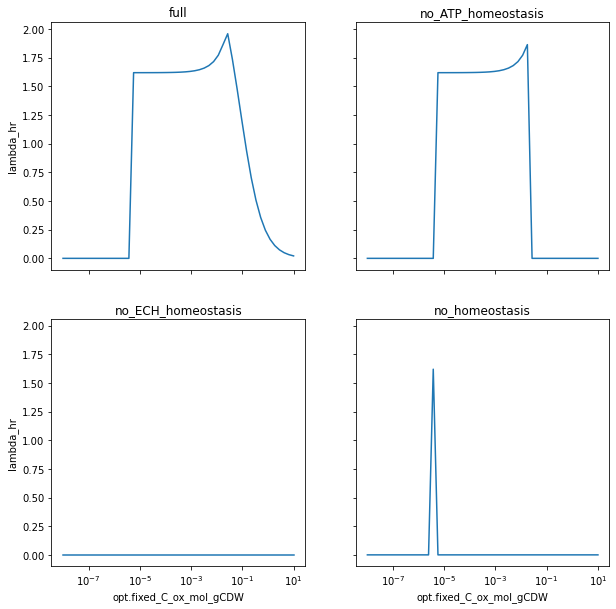

In [30]:
mosaic = [['full', 'no_ATP_homeostasis'], ['no_ECH_homeostasis', 'no_homeostasis']]
fig, axs = plt.subplot_mosaic(sharey=True, sharex=True, mosaic=mosaic, figsize=(10, 10))
for i, label in enumerate(lam_dict.keys()):
    my_df = conc_df[conc_df['model'] == label]
    plt.sca(axs[label])
    plt.xscale('log')
    sns.lineplot(x='opt.fixed_C_ox_mol_gCDW', y='lambda_hr', data=my_df)
    plt.title(label)

plt.show()

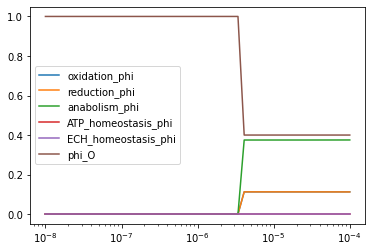

In [19]:
cols = [c for c in conc_df.columns if c.endswith('_phi')] + ['phi_O']
plt.figure()
plt.xscale('log')
for c in cols:
    mask = conc_df['model'] == 'full'
    masked = conc_df[mask]
    plt.plot(masked['C_ox_conc'], masked[c], label=c)
plt.legend()
plt.show()

In [28]:
print('Optimizing over a range of fixed lambda values...')
lambdas = np.arange(0.1, 2.8, 0.01)
results = []

for lam_val in lambdas:
    # Make fresh parameters with a new max_lambda_hr
    params = GrowthRateOptParams(min_phi_O=0.4, max_lambda_hr=lam_val,
                                 maintenance_cost=0, fixed_C_ox=DEFAULT_C_OX,
                                 **DEFAULT_OPT_VALS)
    
    # Optimize the growth rate given the parameters
    opt, opt_prob = lam.maximize_growth_rate(params)
    d = lam.results_as_dict(opt_prob, params)
    results.append(d)

phi_df = pd.DataFrame(results)

Optimizing over a range of fixed lambda values...


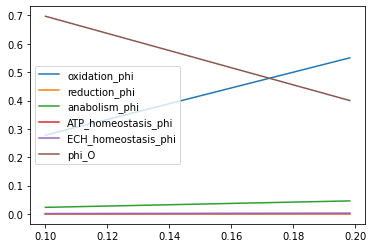

In [27]:
cols = [c for c in phi_df.columns if c.endswith('_phi')] + ['phi_O']
for c in cols:
    plt.plot(phi_df.lambda_hr, phi_df[c], label=c)
plt.legend()
plt.show()

In [8]:
print('Optimizing over a range of fixed Z_C,B values...')
# Sweep a range of biomass ZC values
ZCBs = np.arange(-3, 3.01, 0.05)

results = []
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

for z in ZCBs:
    # Test with and without ATP homeostasis -- first with
    ref_lam = lmm.copy()
    ref_lam.set_ZCB(z)
    # Note we are fixing phi_O here to highlight the contribution of phi_H
    params = GrowthRateOptParams(phi_O=0.4, **DEFAULT_OPT_VALS)
    m, opt_p = ref_lam.maximize_growth_rate(params)
    d = ref_lam.results_as_dict(opt_p, params)
    results.append(d)

    # Now without -- seting max_phi_H = 0
    params_nh = GrowthRateOptParams(phi_O=0.4, max_phi_H=0,
                                    **DEFAULT_OPT_VALS)
    m, opt_p = ref_lam.maximize_growth_rate(params_nh)
    d = ref_lam.results_as_dict(opt_p, params_nh)
    results.append(d)

ZCB_sensitivity_df = pd.DataFrame(results)

Optimizing over a range of fixed Z_C,B values...


/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)
/Users/flamholz/Documents/workspace/redox-proteome/notebooks/linear_opt/lin_metabolism.py:725: RuntimeWarning: divide by zero encountered in scalar divide
  S6_lb = num / denom
/opt/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1343: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the k

<AxesSubplot: xlabel='ZCB', ylabel='lambda_hr'>

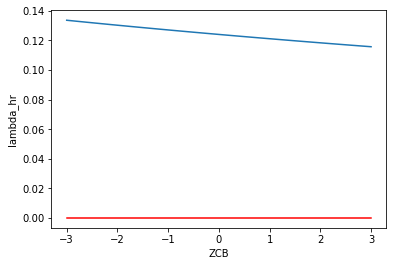

In [18]:
mask = ZCB_sensitivity_df['opt.max_phi_H_value'] != 0
sns.lineplot(x='ZCB', y='lambda_hr', data=ZCB_sensitivity_df[mask])
mask = ZCB_sensitivity_df['opt.max_phi_H_value'] == 0
sns.lineplot(x='ZCB', y='lambda_hr', data=ZCB_sensitivity_df[mask], color='red')

In [16]:
ZCB_sensitivity_df['opt.max_phi_H_value'].unique()

array([nan,  0.])